In [1]:
from info import * 
from preprocess import *
from utils import *

import sys
import cProfile
from functools import wraps, lru_cache
from warnings import simplefilter

user = os.path.expanduser('~')
sys.path.insert(0, f'{user}/Dropbox/Projects/social_navigation_analysis/tests')
from test_utils import *

# TODO: automatic unit testing
# TODO speedup w/ less memory: caching (@lru_cache(maxsize=12)), parallelize, decorators, generators, better data typing, figure out -> from numba import njit
# TODO: data type automatically? 
# TODO: need an ANGLE consistency variable...?

//anaconda3/envs/social_navigation_analysis/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
//anaconda3/envs/social_navigation_analysis/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


# ComputeBehavior (w/ auto-testing)

In [2]:
from numpy import asarray, linalg
import numpy.lib.recfunctions as rfn
from scipy.spatial import ConvexHull, Delaunay, procrustes
from shapely.geometry import Polygon, MultiPoint, mapping
import alphashape
import pycircstat

data = pd.read_excel(example_org_file)
compute = ComputeBehavior2(data)
compute.run()
list(compute.out.columns) # this will be the standard

# unittest.main(argv=['first-arg-is-ignored'], exit=False) # arguments are to run in nb
%run -i '../tests/test_ComputeBehavior2.py'
#cProfile.run("compute.run()") # profile time

...........
----------------------------------------------------------------------
Ran 11 tests in 0.084s

OK


In [ ]:
# TODO: create a key for the different variables
class ComputeBehavior2:

    __slots__ = ["file_path", "sub_id", "data",
                 "decision_types", "weight_types", "coord_types",  
                 "demean_coords", "out"] # assign to optimize memory

    def __init__(self, file=None, decision_types=False, weight_types=False, coord_types=False, demean_coords=False):
        '''
            Class to compute behavioral geometry

            Arguments
            ---------
            file : str, dataframe or None
                
            decision_types : bool (optional, default=False)
                'current'
                'previous' 
            weight_types : bool (optional, default=False)
                'constant'
                'linear_decay'
                'exponential_decay'
            coord_types : bool (optional, default=False)
                'actual'
                'counterfactual' 
            demean_coords : bool (optional, default=False)
                Whether to mean center the coordinates  

            Raises
            ------
            Exception : 
                _description_

        '''
    
        warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning) # fragmented df...TODO maybe fix??
        np.seterr(divide='ignore', invalid='ignore') # division by 0 in some of our operations
            
        #---------------------------------------------------------------
        # load in data
        #---------------------------------------------------------------
        
        if file is None:

            self.file_path = None
            self.sub_id    = None   

        else:

            if type(file) is not str: # eg for easy unittesting
                
                self.file_path = None
                self.sub_id    = None
                self.data      = copy.deepcopy(file)
            
            else: 
                
                self.file_path = Path(file)
                self.sub_id    = self.file_path.stem.split('_')[1] # expects a filename like 'snt_subid_*'
                if self.file_path.suffix == '.xlsx':  self.data = copy.deepcopy(pd.read_excel(self.file_path, engine='openpyxl'))
                elif self.file_path.suffix == '.xls': self.data = copy.deepcopy(pd.read_excel(self.file_path))
                elif self.file_path.suffix == '.csv': self.data = copy.deepcopy(pd.read_csv(self.file_path))
                else: raise Exception(f'File type {self.file_path.suffix} not recognized')
    
                self.check_input(self.data, (63, self.data.shape[1])) # should have 63 trials
 
            #---------------------------------------------------------------
            # clean up input
            #---------------------------------------------------------------
            
            # get decisions in 2d
            if 'affil' not in self.data.columns: # for backward compatability
                self.data['decision'] = self.data['decision'].astype(int)
                dim_mask  = np.vstack([(self.data['dimension'] == 'affil').values, 
                                       (self.data['dimension'] == 'power').values]).T
                self.data[['affil', 'power']] = self.data['decision'].values[:, np.newaxis] * (dim_mask * 1)
                            
            # TODO: maybe should already convert into a numpy structured array?
            # ensure correct data types
            type_dict = {'decision_num': int, 'scene_num': int, 'dimension': object,
                         'char_role_num': int, 'char_decision_num': int,
                         'button_press': int, 'decision': int, 'affil': int, 'power': int,
                         'reaction_time': float, 'onset': float}
            for col in self.data: 
                if self.data[col].dtype != type_dict[col]:
                    self.data[col] = self.data[col].astype(type_dict[col])

        #---------------------------------------------------------------
        # what to compute
        #---------------------------------------------------------------

        # types of decisions, weighting, coordinates
        if decision_types is True:    self.decision_types = ['current', 'previous']
        elif decision_types is False: self.decision_types = ['current']
        else:                         self.decision_types = decision_types
        
        if weight_types is True:      self.weight_types = ['constant', 'linear_decay', 'exponential_decay']
        elif weight_types is False:   self.weight_types = ['constant']
        else:                         self.weight_types = weight_types
        
        if coord_types is True:       self.coord_types = ['actual', 'counterfactual']
        elif coord_types is False:    self.coord_types = ['actual']
        else:                         self.coord_types = coord_types

        self.demean_coords = demean_coords

    @staticmethod
    def check_input(input, exp_shapes):
        ''' check the shape of input arrays'''
        if type(exp_shapes) != list: exp_shapes = [exp_shapes]
        matches = np.sum([input.shape == e for e in exp_shapes])
        if matches == 0:
            str_ = (' ').join([f'({e[0]},{e[1]})' for e in exp_shapes])
            raise Exception(f'Shape mismatch: {input.shape}!= any of expected shapes: {str_}')
        else:
            return True

    #---------------------------------------------------------------------------------------
    # defining the trajectories in cartesian and polar coordinates
    #---------------------------------------------------------------------------------------
    
    @staticmethod
    def get_decisions(decisions_raw, which='current', shift_by=1, replace_with=0, float_dtype='float32'):
        '''
            Arguments
            ---------
            decisions_raw : _type_
            which : str (optional, default='current')
            shift_by : int (optional, default=1)
            replace_with : int (optional, default=0)

            Returns
            -------
            _type_ 
                _description_

        '''
        if which == 'current':
            return np.array(decisions_raw, dtype=float_dtype)
        elif which == 'previous':
            decisions_prev = np.ones_like(decisions_raw) * replace_with
            decisions_prev[shift_by:] = np.array(decisions_raw)[0:-shift_by]
            return np.array(decisions_prev, dtype=float_dtype)

    @staticmethod
    def weight_decisions(decisions, weights='constant', float_dtype='float32'):
        '''
            Arguments
            ---------
            decisions : _type_
            weights : str (optional, default='constant')
        '''
        n_trials = len(decisions)
        if weights == 'constant': 
            decisions_weighted = decisions * np.ones(n_trials)[:,None]
        elif weights == 'linear_decay': 
            decisions_weighted = decisions * utils.linear_decay(1, 1/n_trials, n_trials)[:,None]
        elif weights == 'exponential_decay': 
            decisions_weighted = decisions * utils.exponential_decay(1, 1/n_trials, n_trials)[:,None]
        return np.array(decisions_weighted, dtype=float_dtype)

    @staticmethod
    def get_coords(decisions, which='actual', demean=False, float_dtype='float32'):
        '''
            Arguments
            ---------
            decisions : array of shape (n_trials, 2)
            which : str (optional, default='actual')
                'actual' or 'counterfactual' 
            demean : bool (optional, default=False)
                whether to demean coordinates or not 

            Returns
            -------
        '''
        if which == 'actual':
            coords = np.nancumsum(decisions, axis=0)
        elif which == 'counterfactual':
            coords = (np.nancumsum(decisions, axis=0) - (2 * decisions))
        if demean: coords = coords - np.mean(coords, axis=0)
        return np.array(coords, dtype=float_dtype)

    @staticmethod
    def make_3d(U, V, ori):
        ''' 
            add 3rd dimension to vector arrays U & V & origin coordinates
            - U are vectors of interest, z-axis will vary w/ number of interactions
            - ori will be subtracted from U, z-axis will vary w/ number of interactions
            - V are reference vectors, z-axis is constant
        '''

        if V.ndim == 2:   V = V[0]
        if ori.ndim == 1: ori = ori[np.newaxis]

        num = np.arange(1, len(U) + 1)[:,np.newaxis]
        U   = np.concatenate([U, num], axis=1) # changes w/ num of interactions
        V   = np.repeat(np.hstack([V, len(U)])[np.newaxis], len(U), axis=0) # fixed
        ori = np.concatenate([np.repeat(ori, len(U), axis=0), num], axis=1) # changes w/ num of interactions   

        return U, V, ori                           
 
        ''' 

        '''
          
    @staticmethod
    def calc_angle(coords, ref_frame=None, n_dim=2, float_dtype='float32'):
        '''
            Arguments
            ---------
            coords : _type_
                _description_
            ref_frame : _type_
                _description_
            n_dim : int (optional, default=2)
                _description_ 

            Returns
            -------
            angles array  
            
            - origin
            --- neu: (0, 0, [interaction # (1:12)]) - note that 'origin' moves w/ interactions if in 3d
            --- pov: (6, 0, [interaction # (1:12)])
            - reference vector (ref_vec)
            --- neu: (6, 0, [max interaction (12)])
            --- pov: (6, 6, [max interaction (12)])
            - point of interaction vector (poi): (curr. affil coord, power coord, [interaction # (1:12)])
            to get directional vetctors (poi-ori), (ref-ori)
            - angle direction 
        '''

        # default: counterclockwise angle of vector from the origin against the positive x-axis
        if ref_frame is None: 
            ref = np.array([6,0])
            ori = np.array([0,0])
            drn = False
        else: 
            ref, ori, drn = ref_frame['ref_vec'], ref_frame['origin'], ref_frame['angle_drn']
       
        # add a third dimension if needed
        if n_dim == 3: 
            coords, ref, ori = ComputeBehavior2.make_3d(coords, ref[0], ori)
            drn = None # may not be correct for neutral origin... not sure yet

        return np.array(utils.calculate_angle(coords-ori, ref-ori, force_pairwise=False, direction=drn), dtype=float_dtype)[:, np.newaxis] # maybe add this into this class?

    @staticmethod
    def calc_distance(coords, origin, float_dtype='float32'):
        return np.array([linalg.norm(v) for v in coords-origin], dtype=float_dtype)[:, np.newaxis]

    #---------------------------------------------------------------------------------------
    # other geometry
    #---------------------------------------------------------------------------------------

    # TODO: figure out to use decorator w/ generator expression instread of list comprehension
    @staticmethod
    def cumulative(func):
        ''' decorator to compute measures cumulatively '''
        @wraps(func)
        def wrapper(values):
            return np.vstack([func(values[:v, :]) for v in range(len(values))])
        return wrapper

    @staticmethod
    def calc_cumulative_mean(values, resp_mask=None, which='linear', float_dtype='float32'):  

        if resp_mask is None: resp_mask = np.ones(values.shape, dtype=bool) # idk?
        # resp_mask = np.isfinite(values)
        if resp_mask.ndim == 1: resp_mask = resp_mask[:, np.newaxis]
        if values.ndim == 1: values = values[:,np.newaxis] # or broadcast?
        
        if which == 'linear':
            return np.array(np.nancumsum(values, axis=0) / 
                            np.nancumsum(resp_mask, axis=0), dtype=float_dtype)

        elif which == 'circular':
            means = np.zeros_like(values, dtype=float_dtype)
            for c in range(len(values)):
                if resp_mask[c]: means[c] = pycircstat.mean(values[:c])
                else:            means[c] = means[c-1] # replace w/ previous (or nan?)
            return np.array(means, dtype=float_dtype)

    @staticmethod
    def simulate_consistent_decisions(decisions, float_dtype='float32'):
        ''' 
            generate perfectly consistent and perfectly inconsistent decisions given a decision pattern
        '''
        resp_mask  = np.abs(decisions) 
        con_decs   = resp_mask * 1
        incon_decs = np.zeros_like(resp_mask)
        for n_dim in range(2): 
            dim_mask = resp_mask[:, n_dim] != 0 
            incon_decs[dim_mask, n_dim] = [n if not i % 2 else -n for i, n in enumerate(con_decs[dim_mask, n_dim])] # flip every other sign
        return [np.array(incon_decs, dtype=float_dtype), np.array(con_decs, dtype=float_dtype)]

    @staticmethod
    def calc_cumulative_consistency(decisions, float_dtype='float32'):
        '''
            Arguments
            ---------
            decisions : _type_
                _description_
            float_dtype : str (optional, default='float32')
                _description_ 

            Returns
            -------
            _type_ 
                _description_

        '''
        # aliases
        cum_mean = ComputeBehavior2.calc_cumulative_mean

        # simulate range of possible behavior: minimum and maximum consistency, given charactr pattern & response pattern
        resp_mask  = np.abs(decisions)
        incon_decs, con_decs = ComputeBehavior2.simulate_consistent_decisions(decisions)  
        min_coords = np.nancumsum(incon_decs, axis=0) / np.nancumsum(resp_mask, axis=0) # adjust for response counts at each time point
        max_coords = np.nancumsum(con_decs, axis=0) / np.nancumsum(resp_mask, axis=0)

        # 1d consistency = abs value coordinate, scaled by min and max possible coordinate  
        cum_mean         = cum_mean(decisions, resp_mask, 'linear')
        consistency_cart = (np.abs(cum_mean) - min_coords) / (max_coords - min_coords) # min max scaled

        # 2d consistency = decision vector length, scaled by min and max possible vector lengths
        min_r, max_r  = (np.array([linalg.norm(v) for v in min_coords]), np.array([linalg.norm(v) for v in max_coords]))
        cum_mean_r    = np.array([linalg.norm(v) for v in cum_mean])
        consistency_r = ((cum_mean_r - min_r) / (max_r - min_r))[:, np.newaxis]
        
        # return both dimensions separately & 2d
        consistency = np.hstack([consistency_cart, consistency_r])
        consistency = rfn.unstructured_to_structured(consistency, np.dtype([('affil_consistency', float_dtype),
                                                                            ('power_consistency', float_dtype),
                                                                            ('consistency', float_dtype)]))
        return consistency                                                

    @staticmethod
    def calc_polygon(coords, alpha=0):
        ''' returns vertices & polygon from a set of 2D coordinates
            can be convex or concave, controlled by alpha parameter
        '''
        hull   = alphashape.alphashape(np.array(coords), alpha) 
        hull_vertices = np.array(mapping(hull)['coordinates'][0])
        return [geometry.Polygon(hull_vertices), hull_vertices]

    @staticmethod
    def calc_shape_size(coords, float_dtype="float32"):
        ''' just for convex hull 
            uses scipy: in 2D, area & volume mean perimeter & area, respectively
        '''
        try: 
            convexhull = ConvexHull(coords) 
            return np.array([convexhull.area , convexhull.volume], dtype=float_dtype) 
        except:
            return np.array([np.nan, np.nan], dtype=float_dtype)

    @staticmethod
    def calc_quadrant_overlap(coords, float_dtype="float32"):
        quad_vertices = np.array([[[0,0], [6,0], [6,6],  [0,6]],
                                  [[-6,0],[0,0], [0,6],  [-6,6]],
                                  [[0,0], [-6,0],[-6,-6],[0,-6]],
                                  [[6,0], [0,0], [0,-6], [6,-6]]])
        try: 
            convexhull = ConvexHull(coords)
            polygon    = Polygon(coords[convexhull.vertices])
            return np.array([polygon.intersection(Polygon(v)).area / polygon.area for v in quad_vertices], dtype=float_dtype)
        except:
            return np.array([np.nan, np.nan, np.nan,np.nan])

    @staticmethod
    def calc_centroid(coords, float_dtype='float32'):
        try: 
            return asarray(Polygon(coords).convex_hull.centroid.coords, dtype=float_dtype)
        except: 
            return np.array([np.nan, np.nan], dtype=float_dtype)

    #---------------------------------------------------------------------------------------
    # main functions
    #---------------------------------------------------------------------------------------

    @staticmethod
    def calc_coords(indices, data, decisions='current', weights='constant', coords='actual', demean_coords=False, float_dtype='float32'):

        # aliases
        cumulative  = ComputeBehavior2.cumulative
        cum_mean    = ComputeBehavior2.calc_cumulative_mean
        compute_it  = ComputeBehavior2

        # weighted decisions & cartesian coordinates
        decisions_raw = data[['affil', 'power']].values
        resp_mask     = decisions_raw != 0

        decisions_selected = compute_it.get_decisions(decisions_raw, which=decisions)
        decisions_weighted = compute_it.weight_decisions(decisions_selected, weights=weights) 
        coordinates        = compute_it.get_coords(decisions_weighted, which=coords, demean=demean_coords)

        # summary variables
        coords_mean        = cum_mean(decisions_weighted, resp_mask, which='linear') # mean of coords - MAYBE SHOULD BE DECISIONS INSTED?
        coords_centroid    = cumulative(compute_it.calc_centroid)(coordinates) # center of coords

        coords = np.hstack([indices[:,np.newaxis], np.sum(resp_mask, axis=1)[:,np.newaxis], decisions_weighted, coordinates, coords_mean, coords_centroid])
        coords = rfn.unstructured_to_structured(coords, np.dtype([('trial_index', 'uint16'), ('responded', 'bool'), 
                                                                  ('affil_decision', float_dtype), ('power_decision', float_dtype),
                                                                  ('affil_coord', float_dtype), ('power_coord', float_dtype),
                                                                  ('affil_mean', float_dtype), ('power_mean', float_dtype), 
                                                                  ('affil_centroid', float_dtype), ('power_centroid', float_dtype)]))
        return coords
        
    @staticmethod
    def calc_polar(coords, resp_mask=None, origins=['neu', 'pov'], float_dtype='float32'):

        # aliases
        cum_mean   = ComputeBehavior2.calc_cumulative_mean
        compute_it = ComputeBehavior2

        ref_frames = {'neu': {'origin': np.array([[0,0]]), 'ref_vec': np.array([[6,0]]), 'angle_drn': False},
                      'pov': {'origin': np.array([[6,0]]), 'ref_vec': np.array([[6,6]]), 'angle_drn': None}} 

        out, colnames = [], [] # appending to lists in a loop is faster
        for origin in origins:

            distances  = compute_it.calc_distance(coords, ref_frames[origin]['origin'])
            dist_mean  = cum_mean(distances, resp_mask, which='linear')

            out.append([distances, dist_mean])
            colnames.extend([f'{origin}_dist', f'{origin}_dist_mean'])

            for n_dim in [2, 3]:

                angles     = compute_it.calc_angle(coords, ref_frames[origin], n_dim=n_dim)    
                angle_mean = cum_mean(angles, resp_mask, which='circular')

                out.append([angles, angle_mean])
                colnames.extend([f'{origin}_{n_dim}d_angle', f'{origin}_{n_dim}d_angle_mean'])

        polar = rfn.unstructured_to_structured(np.concatenate(out, axis=0).squeeze().T, np.dtype([(col, float_dtype) for col in colnames]))
        return polar

    @staticmethod
    def calc_shape(coords, float_dtype='float32'):
        ''' probably better to compute over multiple character trials so can estimate a shape '''

        # aliases
        cumulative = ComputeBehavior2.cumulative     
        compute_it = ComputeBehavior2

        # 2d
        if coords.shape[1] == 2:
            size     = cumulative(compute_it.calc_shape_size)(coords)
            size_pov = cumulative(compute_it.calc_shape_size)(np.vstack([np.array([6,0]), coords])) # include pov, then drop it to make length correct
            overlap  = cumulative(compute_it.calc_quadrant_overlap)(coords)
            shape_measures = rfn.unstructured_to_structured(np.hstack([size, size_pov[1:], overlap]), 
                                                            np.dtype([('perimeter', float_dtype),     ('area', float_dtype), 
                                                                      ('pov_perimeter', float_dtype), ('pov_area', float_dtype), 
                                                                      ('Q1_overlap', float_dtype),    ('Q2_overlap', float_dtype),
                                                                      ('Q3_overlap', float_dtype),    ('Q4_overlap', float_dtype)]))
        # 3d
        elif coords.shape[1] == 3:
            size = cumulative(compute_it.calc_shape_size)(coords)
            shape_measures = rfn.unstructured_to_structured(size, np.dtype([('surface_area', float_dtype), ('volume', float_dtype)]))
            
        return shape_measures
 

    def run(self, float_dtype='float32', labels='char_role_num'):
        ''' labels controls how the trials are split up to calculate trajectories '''

        # aliases
        unstructure = rfn.structured_to_unstructured
        compute_it  = ComputeBehavior2
 
        # get the labels
        if labels is None:        labels = np.ones(len(self.data)) # 1 trajectory
        elif type(labels) == str: labels = self.data[labels] 
        else:                     
            if len(labels) != self.data.shape[0]: 
                raise Exception(f'The labels have a different length {len(labels)} than the data {self.data.shape[0]}')
        label_list = np.unique(labels)

        self.out = {}
        types = [[dt, wt, ct] for dt in self.decision_types for wt in self.weight_types for ct in self.coord_types]
        for dt, wt, ct in types:
        
            # compute trajecotry-specific coordinates
            cart_coords, polar_coords, shape_metrics, consistency = [], [], [], []
            for label in label_list:

                ixs = np.where(labels == label)[0]
                cart = compute_it.calc_coords(ixs, self.data.loc[ixs, ['dimension', 'button_press', 'affil', 'power']], 
                                              decisions=dt, weights=wt, coords=ct, 
                                              demean_coords=self.demean_coords, float_dtype=float_dtype)
                cart_coords.append(cart)
                polar_coords.append(compute_it.calc_polar(unstructure(cart[['affil_coord','power_coord']])))
                
                consistency.append(compute_it.calc_cumulative_consistency(unstructure(cart[['affil_decision','power_decision']]))) 

            out_df = pd.concat([pd.DataFrame(np.hstack(cart_coords)), 
                                pd.DataFrame(np.hstack(polar_coords)), 
                                pd.DataFrame(np.hstack(consistency))], axis=1)
            out_df.sort_values(by='trial_index', inplace=True) # IMPORTANT!
            out_df.reset_index(drop=True, inplace=True) # IMPORTANT!
            
            # calculate shape of overall space

            # - 2d shape
            all_coords       = out_df[['affil_coord','power_coord']].values
            shape_metrics_2d = pd.DataFrame(compute_it.calc_shape(all_coords, float_dtype=float_dtype))

            # - 3d shape
            all_coords       = out_df[['affil_coord','power_coord']].values
            all_coords_3d    = np.hstack([all_coords, self.data['char_decision_num'].values[:,np.newaxis]])
            shape_metrics_3d = pd.DataFrame(compute_it.calc_shape(all_coords_3d, float_dtype=float_dtype))
            
            shape_metrics = pd.concat([shape_metrics_2d, shape_metrics_3d], axis=1)
            
            # calculate cumulative means across all trials
            cum_mean = compute_it.calc_cumulative_mean
            cols = out_df.columns
            # resp_mask = out_df['responded'].values
            for col in cols:
                if (col not in ['trial_index', 'responded', 'affil_decision', 'power_decision']) & ('mean' not in col):
                    if 'angle' in col:
                        out_df[f'{col}_overallmean'] = cum_mean(out_df[col].values, which='circular') # no response mask: just compute over non-nans
                    else:
                        out_df[f'{col}_overallmean'] = cum_mean(out_df[col].values, which='linear')

            # if more than one way to measure decisions, coordinates, then output a dictionary
            task = self.data[['decision_num', 'dimension', 'scene_num', 'char_role_num', 'char_decision_num']]
            df = pd.concat([task, out_df, shape_metrics], axis=1)
            df.reset_index(drop=True, inplace=True)
            del df['trial_index']
            if len(types) > 1: self.out[f'{dt}_{wt}_{ct}'] = df
            else:              self.out = df



# Plotting the area

In [3]:
from shapely.geometry import MultiPoint, mapping
from descartes import PolygonPatch
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

sys.path.insert(0, f"{os.path.expanduser('~')}/Dropbox/Projects/toolbox/toolbox")
import circ_stats

def angle_to_vec_unit(angle, dtype='float32'):
    '''
        convert an angle in radians to unit vector
        assumes counterclockwise angle
        unit vector is agnostic to distance
    '''
    angle = np.array(angle, dtype=dtype) # in case its a list, etc
    return np.hstack([np.cos(angle), np.sin(angle)]).astype(dtype).T

def polar_to_vec_comps(angle, dist, dtype='float32'):
    '''
        convert an angle (radians) and distance to the x & y components of the vector
        returns an array of shape: [n_obs, 2 (x/y)]
    '''
    angle = np.array(angle, dtype=dtype) 
    dist  = np.array(dist, dtype=dtype)
    return np.hstack([dist*np.cos(angle), dist*np.sin(angle)]).astype(dtype)

# having the problem of the origin coordinate not always being included in the concave solution...
def sort_vertices_counterclockwise(vertices):
    angles = [np.arctan2(*v) for v in vertices]
    A = np.hstack([np.array(angles)[:,np.newaxis], vertices])
    sorted_by_angle = A[A[:, 0].argsort()]
    return sorted_by_angle[:, 1:] # return only 

def get_cmap_colors(cmap):
    # usage: get_cmap_colors(cm.get_cmap('plasma', 101))
    return [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]


In [3]:
# data = pd.read_excel(example_org_file)
# coords = compute.out['current_constant_actual'][['affil_coord','power_coord']].values

/Users/matthew/opt/anaconda3/envs/social_navigation_task/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


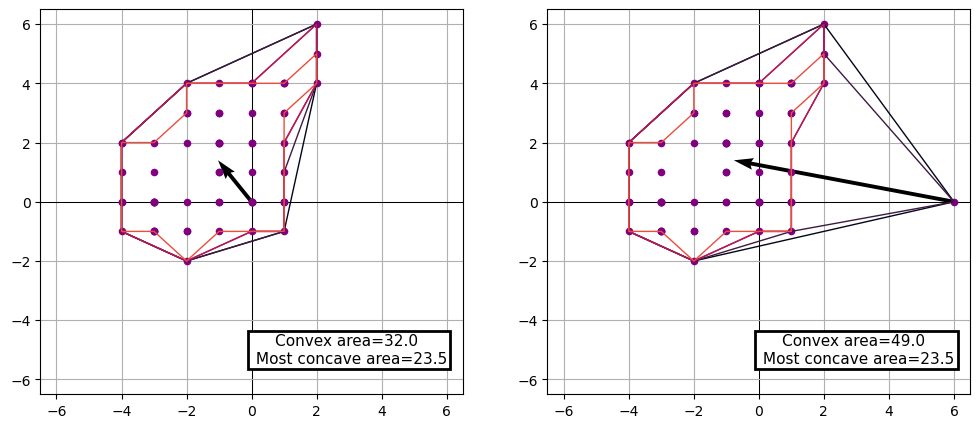

In [5]:
# TODO: error checking

ref_frames = {'neu': {'origin': np.array([[0,0]]), 'ref_vec': np.array([[6,0]]), 'angle_drn': False},
              'pov': {'origin': np.array([[6,0]]), 'ref_vec': np.array([[6,6]]), 'angle_drn': None}} 

plt.rc('axes', axisbelow=True)
figsize = (12,5)
fig, axs = plt.subplots(1, 2, figsize=figsize)
color = 'purple'
colors = get_cmap_colors(sns.color_palette("rocket", as_cmap=True))
for r, (ori, ref_frame) in enumerate(ref_frames.items()):  
    
    # grid lines 
    axs[r].axis([-6.5, 6.5, -6.5, 6.5])
    axs[r].grid()
    b = axs[r].get_xgridlines()[4] # outline axis
    b.set_color('black')
    b.set_linewidth(.75)
    b = axs[r].get_ygridlines()[4]
    b.set_color('black')
    b.set_linewidth(.75)    
    axs[r].set_xlabel('')
    axs[r].set_ylabel('')

    # (1) plotting average vector
    mean_xy = np.mean(coords - ref_frame['origin'], axis=0)
    axs[r].quiver(ref_frame['origin'][0][0], ref_frame['origin'][0][1], 
                  mean_xy[0], mean_xy[1], 
                  units='xy', scale=1, color='black', 
                  width=.025 * figsize[1]) 

    # (2) plotting shape 
    coords_ = np.vstack([ref_frame['origin'], coords]) # add origin in
    axs[r].scatter(*zip(*coords_), s=20, color='purple')

    areas = []
    for a, alpha in enumerate(np.arange(0, 1, .2)):
        hull = alphashape.alphashape(coords_, alpha) # convex hull when alpha = 0, concave when not
        hull_vertices = np.array(mapping(hull)['coordinates'][0]) # hull.exterior.coords
        # hull.exterior.coords
        areas.append(hull.area)
        axs[r].add_patch(PolygonPatch(hull, color=colors[a*40], fill=None)) 

    # add area text to plot
    axs[r].text(3, -5, 
                f"""Convex area={areas[0]} \n Most concave area={areas[-1]}""", 
                ha="center", va="center", size=11,
                bbox=dict(boxstyle="square, pad=0.2", fc="white", ec="black", lw=2))

plt.show()


# DEV: speed up angle calculations

In [4]:
# TODO: speed this up!

def _coincident_vectors(u, v):
    ''' Checks if vectors (u & v) are the same or scalar multiples of each other'''
    return np.dot(u, v) * np.dot(u, v) == np.dot(u, u) * np.dot(v, v)


def angle_between_vectors(u, v, direction=None, verbose=False):
    '''
        Compute elementwise angle between sets of vectors u & v
            
        uses np.arctan2(y,x) which computes counterclockwise angle [-π, π] between origin (0,0) and x, y
        clockwise v. counterclockwise: https://itecnote.com/tecnote/python-calculate-angle-clockwise-between-two-points/  
        included: ADD LINK

        TODO: make pairwise..?

        Arguments
        ---------
        u : array-like
            vector
        v : array-like
            another vector
        direction : None, True or False (optional, default=None)
            None == Included
            True == Clockwise 360
            False == Counterclockwise 360 
        verbose : bool (optional, default=False)
             
        Returns
        -------
        float 
            angle in radians 

        [By Matthew Schafer; github: @matty-gee; 2020ish]
    '''

    #     if U.shape != V.shape:
    #         if verbose: print(f'Different shape vectors: U={U.shape}, V={V.shape}. Assuming smaller is reference.')
    #         if len(U) < len(V): U = np.repeat(np.expand_dims(U, 0), len(V), axis=0)
    #         else:               V = np.repeat(np.expand_dims(V, 0), len(U), axis=0)
    #     rads = []
    #     for u, v in zip(U, V):        
    # 
    #     
    # if one of vectors is at origin, the angle is undefined but could be considered as orthogonal (90 degrees)
    if ((u==0).all()) or ((v==0).all()): 
        if verbose: print(u, v, 'at least 1 vector at origin; treating as orthogonal')
        rad = np.pi/2

    # if same vectors (or scalar multiples of each other) being compared, no angle between (0 degrees)
    # -- b/c 0-360 degrees, direction matters: make sure the signs are the same too
    elif (_coincident_vectors(u, v)) & all(np.sign(u) == np.sign(v)):
        if verbose: print(u, v, 'same vectors, no angle in between')
        rad = 0 # 0 degrees == 360 degrees == 2*pi radians 

    else:

        if direction is None: 

            # "included" angle from [0,180], [0, π] 
            rad = np.arccos(np.dot(u, v) / (linalg.norm(u) * linalg.norm(v)))
            # equivalent: np.arctan2(l2_norm(np.cross(u, v)), np.dot(u, v))

        elif direction is True: 

            # clockwise angle from [0,360], [0, 2π]
            # -- compute vector angles from origin & take difference, then convert to 360 degrees
            rad = (np.arctan2(*v[::-1]) - np.arctan2(*u[::-1])) % (2 * np.pi)  
        
        elif direction is False:

            # counterclockwise angle from [0,360], [0, 2π]
            # -- compute vector angles from origin & take difference, then convert to 360 degrees
            rad = (np.arctan2(*u[::-1]) - np.arctan2(*v[::-1])) % (2 * np.pi)
            
    return rad


def calculate_angle(U, V=None, direction=None, force_pairwise=True, verbose=False):
    '''
        Calculate angles between n-dim vectors 
        If V == None, calculate U pairwise
        Else, calculate elementwise
        
        TODO: more explanation; find more elegant ways to do this; also adapt other pairwise like functions to have structure

        Arguments
        ---------
        U : array-like
            shape (n_vectors, n_dims)
        V : array-like
            shape (n_vectors, n_dims)
        direction : optional (default=None)
            None : included 180
            False : counterclockwise 360 (wont give a symmetrical matrix)
            True : clockwise 360
            
        Returns
        -------
        numeric 
            pairwise angles in radians

        [By Matthew Schafer; github: @matty-gee; 2020ish]
    '''
    
    # # testing (10-12-22)
    # U = np.random.randint(100, size=(4,2))
    # for V in [None, np.random.randint(100, size=U.shape), 
    # np.random.randint(100, size=(1, U.shape[1])), np.random.randint(100, size=(7, U.shape[1]))]:

    messages = []

    # check/fix shapes
    if U.ndim == 1: 
        U = np.expand_dims(U, 0)
        messages.append('Added a dimension to U')
        
    if V is not None:
        if V.ndim == 1: 
            V = np.expand_dims(V, 0)
            messages.append('Added a dimension to V')

            
    # determine output shape 
    # - 1 set of vectors: pw, square, symm
    if V is None: 
        default = 'pairwise'
        V = U 
        
    # - 2 vectors of same shape
    # -- pw, square, non-symm
    # -- ew, vector
    elif U.shape == V.shape: 
        default = 'elementwise' 

    # - 2 vectors, 1 w/ length==1 & is reference
    # -- pw, vector shape (1,u)
    elif (U.shape[0] > 1) & (V.shape[0] == 1): 
        V = np.repeat(V, len(U), 0) 
        default = 'reference'  
    
    # -- pw, vector shape (v,1)
    elif (U.shape[0] == 1) & (V.shape[0] > 1): 
        U = np.repeat(U, len(V), 0) 
        default = 'reference' 
        
    # - 2 vectors, different lengths
    # -- pw, rectangle 
    else: 
        default = 'pairwise' 
        
    messages.append(f'Calculated {default}')
    
    
    # calculate angles
    # if pairwise dont have to compute every angle.. but gotta be careful abouyt symmetric and not 
    radians = np.zeros((U.shape[0], V.shape[0]))
    for i in range(U.shape[0]):
        for j in range(V.shape[0]):
            radians[i, j] = angle_between_vectors(U[i,:], V[j,:], direction=direction)

            
    # output
    if default == 'pairwise': cols = 'U'
    else:                     cols = 'V'
    radians = pd.DataFrame(radians, index=[f'U{i+1:02d}' for i in range(len(U))], columns=[f'{cols}{i+1:02d}' for i in range(len(V))])

    if not force_pairwise:
        if default == 'reference':
            radians = radians.iloc[:,0].values
        elif default == 'elementwise':
            radians = np.diag(radians)
    if verbose: [print(m) for m in messages]
        
    return radians


# data = pd.read_excel(example_org_file)
# coords = data[['affil','power']].values
# ref = np.array([6,0])
# calculate_angle(coords, ref, force_pairwise=False, direction=None)
# cProfile.run("calculate_angle(coords, ref, force_pairwise=False, direction=None)")

# DEV: automatically optimize data tapes

In [ ]:
# TODO: adapt this for structured numpy arrays?

def data_optimize(df, object_option=False):
    """Reduce the size of the input dataframe
    Parameters
    ----------
    df: pd.DataFrame
        input DataFrame
    object_option : bool, default=False
        if true, try to convert object to category
    Returns
    -------
    df: pd.DataFrame
        data type optimized output dataframe
    """
    # https://towardsdatascience.com/optimize-memory-tips-in-python-3bbb44512937

    # loop columns in the dataframe to downcast the dtype
    for col in df.columns:
        # process the int columns
        if df[col].dtype == 'int':
            col_min = df[col].min()
            col_max = df[col].max()
            # if all are non-negative, change to uint
            if col_min >= 0:
                if col_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif col_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif col_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                else:
                    df[col] = df[col]
            else:
                # if it has negative values, downcast based on the min and max
                if col_max < np.iinfo(np.int8).max and col_min > np.iinfo(np.int8).min:
                    df[col] = df[col].astype(np.int8)
                elif col_max < np.iinfo(np.int16).max and col_min > np.iinfo(np.int16).min:
                    df[col] = df[col].astype(np.int16)
                elif col_max < np.iinfo(np.int32).max and col_min > np.iinfo(np.int32).min:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col]
                    
        # process the float columns
        elif df[col].dtype == 'float':
            col_min = df[col].min()
            col_max = df[col].max()
            # downcast based on the min and max
            if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col]

        if object_option:
            if df[col].dtype == 'object':
                if len(df[col].value_counts()) < 0.5 * df.shape[0]:
                    df[col] = df[col].astype('category')

    return df


# DEV: parallelize at least across subjects

In [50]:
# parallelization
print("Number of processors: ", os.cpu_count())

# import math
# import numpy as np
# from timebudget import timebudget
# import ray

# iterations_count = round(1e7)

# @ray.remote
# def complex_operation(input_index):
#     print("Complex operation. Input index: {:2d}".format(input_index))

#     [math.exp(i) * math.sinh(i) for i in [1] * iterations_count]

# @ray.remote
# def complex_operation_numpy(input_index):
#     print("Complex operation (numpy). Input index: {:2d}".format(input_index))

#     data = np.ones(iterations_count)
#     np.exp(data) * np.sinh(data)

# @timebudget
# def run_complex_operations(operation, input):
    
# 	ray.get([operation.remote(i) for i in input])

# ray.init()

# input = range(10)
# print('Without NumPy')
# run_complex_operations(complex_operation, input)
# print('NumPy')
# run_complex_operations(complex_operation_numpy, input)

# Use generators, other pythonic stuff

In [28]:
# using generators
def get_data(data, labels_column):
    labels = np.unique(data[labels_column].values)
    for label in labels:
        yield data[data[labels_column] == label]
data = pd.read_excel(example_org_file)
my_data = get_data(data, 'char_role_num')

while True:
    try:
        this_data = next(my_data)
    except StopIteration:
        break
    print(this_data)

# tryign to time thingsmore
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print(f'func:{f.__name__} args:{args} took: {te-ts} sec')
        return te-ts
    return wrap

    decision_num dimension  scene_num  char_role_num  char_decision_num  \
0              1     affil          1              1                  1   
1              2     affil          1              1                  2   
2              3     affil          1              1                  3   
3              4     power          2              1                  4   
6              7     power          3              1                  5   
7              8     affil          3              1                  6   
8              9     affil          3              1                  7   
12            13     power          5              1                  8   
13            14     power          5              1                  9   
16            17     affil          5              1                 10   
24            25     power          7              1                 11   
28            29     power          9              1                 12   

      onset  button_pres

# Visualize the different decision weighting schemes...

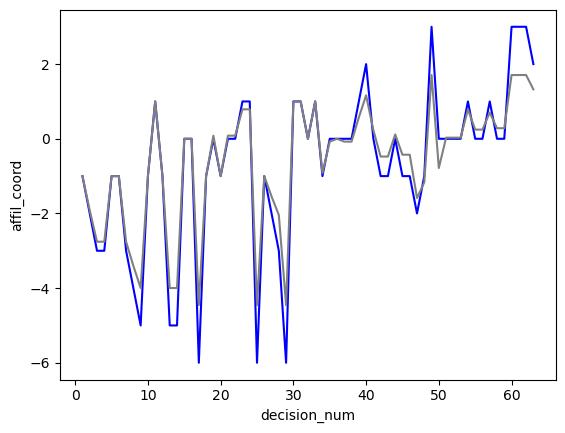

In [68]:
import seaborn as sns
# plot against time
sns.lineplot(data=behavior, x="decision_num", y="affil_coord", color='blue')
# sns.lineplot(data=behavior, x="decision_num", y="affil_coord_cf", color='grey')
sns.lineplot(data=behavior, x="decision_num", y="affil_coord_exponential-decay", color='grey')
# sns.lineplot(data=behavior, x="decision_num", y="power_coord", color='red')
plt.show()